# Tutorial

This is a tutorial for MB-MVPA using task-fMRI data of Mixed-gamble task by Tom et al., 2007. 



### Import the MB-MVPA libarary.

Other libraries(nilean, keras, etc..) dosen't need to be imported.<br>
Because mb-mvpa has wrapping the libararies.<br>
You don't necessarily have to know fMRI libraries like nilearn and machine learning libraries like tensorflow.<br>
<b>MB-MVPA is all you need.</b>

Most of mb-mvpa are wrapping nilearn, tensorflow, Keras and etc., so warning can occur from that libraries.<br>
This page does not print warning because most of them are can be ignored.<br>
You don't need to remove the warning when you are actually using it.

In [ ]:
from time import perf_counter

In [2]:
from mbmvpa.preprocessing.preprocess import DataPreprocessor

/home/cheoljun/.cache/pypoetry/virtualenvs/model-based-fmri-A7ELC43w-py3.7/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


TODO: add original data download link

Data download from AWS S3, ~ <b>1GB</b> (would be under the "Mixed-gamble_task/example_data/").<br>

We provide a small subset (2 subjects) of original Tom's dataset (16 subjects). The fMRI images in the example is preprocessed by conventional fMRI preprocessing pipeline by using 
[*fmriprep*](https://fmriprep.org/en/stable/) v.20.1.0. Please refer to the [original](https://openneuro.org/datasets/ds000005/versions/00001) for more information.

In [3]:
#root = load_example_data("tom")
root = "/data2/project_modelbasedMVPA/PRL"
#save_path = "/data2/project_modelbasedMVPA/PRL"
mask_path = "/data2/project_modelbasedMVPA/ds000005/derivatives/fmriprep/masks"

### Preprocessing fMRI images and behavioral data

MB-MVPA requires primariliy preprocessed task-fMRI experiments data fromatted in conventional [BIDS format](https://bids-specification.readthedocs.io/en/stable/) 

It expects the following organized files. All the naming conventions used here conform with outputs from *fmriprep* v.20.1.0. by Poldrack lab.

The fMRI images are usually located here<br>
<i>{BIDS_ROOT}/derivatives/fmriprep/subject/session/run/func/*nii.gz</i><br>
And the behavior data are located here<br>
<i>{BIDS_ROOT}/subject/session/run/func/*.tsv</i>

In [4]:
s = perf_counter()

dm_model = "prl_fictitious_rp_woa"

def example_adjust(row):
    ## rename data in a row to the name which can match hbayesdm.dd_hyperbolic requirements ##
    if row["outcome"] == 0:
        row["outcome"] = -1
    row["onset"] = row["time_onset"]
    row["duration"] = row["time_choice"] - row["time_onset"]
    return row

def example_filter(row):
    # in the paper, the condition for trial varies in a single run,
    # agent == 0 for making a choice for him or herself
    # agent == 1 for making a choice for other
    # to consider only non-social choice behavior, select only the cases with agent == 0
    return row['choice'] in [1,2]


def example_modulation_dfwise(df_events, param_dict):
    
    df_events = df_events.sort_values(by="onset")
    
    ev = [0,0]
    choices = df_events['choice'].to_numpy()
    outcome = df_events['outcome'].to_numpy()
    modulations = []
    #print(param_dict['eta_pos'], param_dict['eta_neg'])
    eta_pos = float(param_dict['eta_pos'])
    eta_neg = float(param_dict['eta_neg'])
    #print(eta_pos, eta_neg)
    for choice, outcome in zip(choices,outcome):
        choice = int(choice)
        outcome = int(outcome)
        modulations.append(ev[0])
        
        PE  =  outcome - ev[choice-1];
        PEnc = -outcome - ev[2 - choice];
        try:
            if PE >= 0:
                ev[choice-1] += eta_pos * PE;
                ev[2 - choice] += eta_pos * PEnc;
            else :
                ev[choice-1] += eta_neg * PE;
                ev[2 - choice] += eta_neg * PEnc;
        except:
            print(PE)
            
    df_events["modulation"] = modulations
    
    return df_events[['onset','duration','modulation']]



print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

elapsed time: 0.00 minutes


In [5]:
s = perf_counter()

preprocessor = DataPreprocessor(bids_layout=root,
                               #save_path=save_path,
                               mask_path=mask_path,
                               task_name='prl',
                               adjust_function=example_adjust,
                               filter_function=example_filter,
                               modulation_dfwise=example_modulation_dfwise,
                               dm_model=dm_model,
                               mask_threshold=2.58,
                               standardize=True,
                               confounds=[],
                               high_pass=1/128,
                               detrend=False,
                               smoothing_fwhm=6, 
                               zoom=(2,2,2),
                               n_core= 24)

print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

INFO: start loading BIDSLayout
INFO: fMRIPrep is loaded
INFO: MB-MVPA is newly set up.
INFO: MB-MVPA is added as a new derivative
INFO: MB-MVPA is loaded
elapsed time: 0.93 minutes


In [6]:
s = perf_counter()

preprocessor.preprocess(overwrite=True)
#preprocessor.preprocess(overwrite=False,n_core=16)
#preprocessor.X_generator.mask_path = mask_path
#preprocessor.y_generator.run(overwrite=True)
print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

gain_association-test_z_FDR_0.01.nii: 1595/902629
gain_association-test_z_FDR_0.01.nii: 1595/902629
gain_association-test_z_FDR_0.01.nii: 7378/902629
gain_association-test_z_FDR_0.01.nii: 783/902629
gain_association-test_z_FDR_0.01.nii: 9764/902629


0it [00:00, ?it/s]

gain_association-test_z_FDR_0.01.nii: 12969/902629
integrated mask: 22192/902629
zoomed : 2236/116380
INFO: start processing fMRI. [parallel] 24 * 4


4it [08:03, 120.91s/it]


INFO: fMRI processing is done.
Using cached StanModel: cached-prl_fictitious_rp_woa-pystan_2.19.1.1.pkl



Model  = prl_fictitious_rp_woa
Data   = <pandas.DataFrame object>

Details:
 # of chains                    = 4
 # of cores used                = 24
 # of MCMC samples (per chain)  = 4000
 # of burn-in samples           = 1000
 # of subjects                  = 44
 # of (max) trials per subject  = 120

Using cached StanModel: cached-prl_fictitious_rp_woa-pystan_2.19.1.1.pkl
Index(['subject', 'block', 'blockcond', 'trial', 'cond', 'cond1outcomeleft',
       'cond1outcomeright', 'cond2outcomeleft', 'cond2outcomeright',
       'correctkey', 'selected', 'choice', 'iscorrect', 'iscommon', 'outcome',
       'cumval', 'timescan', 'timeonset', 'rt', 'timechoice', 'timefixation',
       'timefeedback', 'timewait', 'timestampscan', 'subjid', 'run', 'session',
       'onset', 'duration'],
      dtype='object')
['subject', 'block', 'block_cond', 'trial', 'cond', 'cond1_outcome_left', 'cond1_outcome_right', 'cond2_outcome_left', 'cond2_outcome_right', 'correct_key', 'selected', 'choice', 'is_correc

In [7]:
preprocessor.summary()

[  fMRIPrep  ] BIDS Layout: ...dMVPA/PRL/derivatives/fmriprep | Subjects: 48 | Sessions: 48 | Runs: 143
[  MB-MVPA   ] BIDS Layout: ...sedMVPA/PRL/derivatives/mbmvpa | Subjects: 47 | Sessions: 47 | Runs: 93


### Load data and shape check

In [8]:
from mbmvpa.data.loader import BIDSDataLoader

In [12]:
s = perf_counter()

loader = BIDSDataLoader(layout=root)
X,y = loader.get_data(subject_wise=False)

print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

elapsed time: 0.85 minutes


In [13]:
print("X", X.shape)
print("y", y.shape)

X (22277, 2236)
y (22277, 1)


In [14]:
voxel_mask = loader.get_voxel_mask()

### Fitting MVPA models & Results

In [15]:
from mbmvpa.models.mvpa_elasticnet import elasticnet

100%|██████████| 2/2 [04:53<00:00, 146.98s/it]


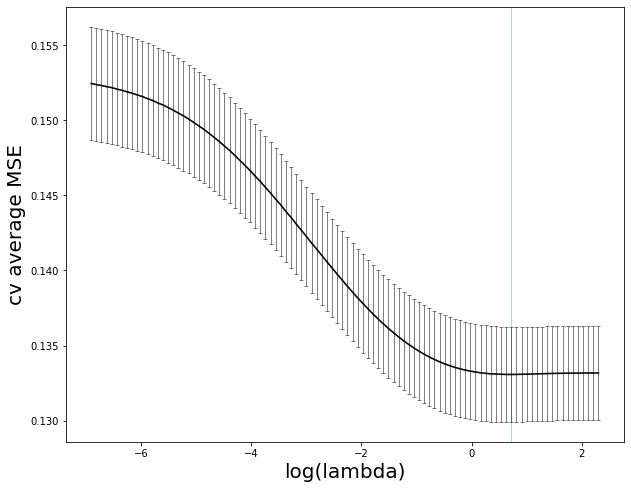

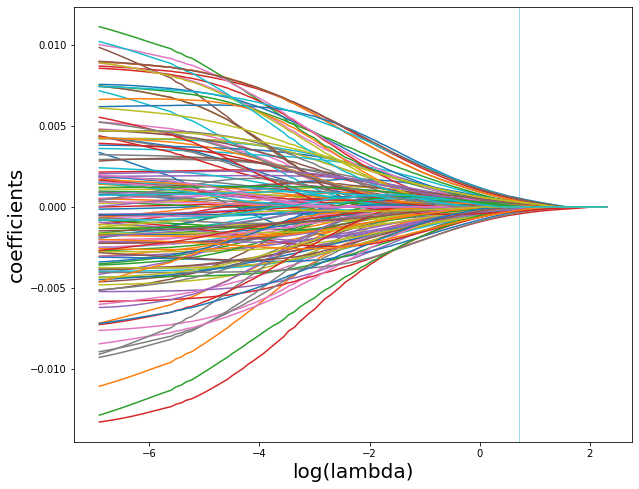

ValueError: too many values to unpack (expected 2)

In [16]:
s = perf_counter()
report = elasticnet(X=X,
                  y=y,
                  voxel_mask=voxel_mask,
                  save_path='.',
                  sigma=0,
                  n_repeat=2)

print(f"elapsed time: {(perf_counter()-s) / 60:.2f} minutes")

In [17]:
from mbmvpa.models.mvpa_elasticnet import elasticnet_crossvalidation

In [18]:
#loader = BIDSDataLoader(layout=root)
X_dict,y_dict = loader.get_data(subject_wise=True)

In [ ]:
metrics_train, metrics_test, reports = elasticnet_crossvalidation(X_dict,
                                                                       y_dict,
                                                                     method='5-fold',
                                                                     n_cv_repeat=1,
                                                                     n_repeat=1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
metrics_train, metrics_test, coefs_train = elasticnet_crossvalidation(X_dict,
                                                                       y_dict,
                                                                     method='loso')

In [ ]:
metrics_test

In [ ]:
metrics_test[:,0]

In [ ]:
metrics_test[:,0][metrics_test[:,1] <0.01]